<h1 align="center">
    <img 
        src="./img/Microsoft-Logo.png" 
        width="400"/>
</h1>
<h1 align="center">
    <b>Practical Guide</b>
</h1>
<h4 align="center">
    for the creation of an AI Solution using an accelerator from the <a href="https://www.ds-toolkit.com/">Data Science Toolkit</a>
</h4>

# What to expect

* **Challenge 1:** *Automatically determine relevant features from the set of questions.*
* **Challenge 2:** *From the dataset, fill out the dataset of the new features defined.*
* **Challenge 3:** *Fit and evaluate regression models using the features of the previous step as inputs and the metrics evaluated as outputs. Then apply SHAP to the newly created models.*

# Challenge 1: *Determine relevant features from the questions*

Here we will use the set of questions and leverage an LLM to determine what would be good features to try and understand the resulting metrics.

## Challenge 1 - Step 1:  Let's import the required packages and libraries.

> This is going to be done in a quiet mode, and only errors will be displayed if they occur. If you like to see what is going to be installed look at the [requirements.txt](./requirements.txt) file.

In summary two main tools will be installed that will be used in this notebook:

* **genAISHAP**. Is the library containing the tools for the DS Toolkit.
* **shap**. A popular library used to help with interpretability.

> Estimated time: 8.4s

In [1]:
import pandas as pd
from dotenv import load_dotenv
from genaishap import Featurizer, GenAIExplainer
import matplotlib.pyplot as plt
import shap
from IPython.display import Markdown, display, clear_output

import ipywidgets as widgets
from IPython.display import display

LOAD_PRECALCULATED_VALUES = True

load_dotenv()
shap.initjs()

### Some definitions:

* **Context prescision:** Measures how much of the generated output is relevant and aligns with the context provided in the input.
* **Context recall:** Measures how much of the relevant information in the input context is included in the output.
* **Faithfulness:** Measures how accurate and truthful the generated output is in relation to the input context and factual correctness. Faithfulness is about avoiding "hallucinations" (made-up or false information).

Below, the dataset of questions, retrieved contexts, generated and expected responses and their corresponding metrics is presented. Remember that this dataset is generated following the same procedure explained in the previous notebook.

In [2]:
df_test_dataset = pd.read_json('./test-dataset.json', orient='records')
df_test_dataset.head(10)

,user_input,retrieved_contexts,response,reference,faithfulness,context_precision,context_recall
0,What is the objective of the Carbon Call initi...,"[In 2022, we also released a preview version o...",The objective of the Carbon Call initiative is...,The objective of Carbon Call is to unify the w...,1.00,1.0,1.000000
1,What are the three key areas that will enable ...,[What’s next \nScope 3 emissions reduction \nM...,The three key areas that will enable the scale...,1 Advancing AI solutions for greater climate i...,0.75,0.0,0.666667
2,How many people in India did Microsoft provide...,"[Chile\nSouth Africa\n16,408 \nBrazil\n340 \n...","Microsoft provided water access to 225,389 peo...","309,921",0.00,0.0,0.000000
3,How many people in Indonesia did Microsoft pro...,"[Chile\nSouth Africa\n16,408 \nBrazil\n340 \n...",The specific number of people in Indonesia pro...,"225,389",1.00,1.0,0.000000
4,How many people in Brazil did Microsoft provid...,"[Chile\nSouth Africa\n16,408 \nBrazil\n340 \n...","Microsoft provided water access to 552,058 peo...","16,408",1.00,1.0,0.000000
5,How many people in Mexico did Microsoft provid...,[Improving access \nto water \nWe continue to ...,"Microsoft provided water access to 309,921 peo...",340,0.00,0.0,1.000000
6,How many more acres of land does Microsoft nee...,[• • \na \n47\n | | | \nCommitments and progre...,"According to Ecosystems Chart 1, Microsoft has...",4998 more acres,0.80,1.0,1.000000
7,What key insight was listed in page 56 of the ...,[Leadership About Highlights How We Operate Wh...,The context provided does not include informat...,25%\nWe are reducing idle power consumption of...,1.00,0.0,0.000000
8,What key insight was listed in page 61 of the ...,[Leadership About Highlights How We Operate Wh...,The context provided does not include informat...,100%\nOur key European and American distributi...,1.00,0.0,0.000000
9,What are the four commitments listed on page 66?,[UN Sustainable Development Goal Apple’s suppo...,The four commitments listed on page 66 are: \n...,1. Using our voice on climate-related public p...,0.25,0.0,0.000000


See an example question below:

In [3]:
df_test_dataset.iloc[2,0]

'How many people in India did Microsoft provide water access to?'

## Challenge 1 - Step 2: Let's extract features from the questions in the dataset

* To do this, we will use the function `Featurizer` from the **genAISHAP** library.
* The features created are then displayed. Remember that these features are generated automatically.

**GenAISHAP** has a utility to automatically create features from the `user_input` entries. This tool, called **featurizer**, works by using an LLM to go through the existing questions in the dataset and extracts what would be relevant pieces of information that would be useful as features in a regression model.

In [4]:

# The Featurizer is part of the DS Toolkit and is able to take the list of provided questions and create a dataset of features for them automatically.
featurizer = Featurizer.from_pandas(df_test_dataset)
featurizer.create_features_using_azure_openai(
    deployment_name="gpt-4o", # Update with the name of your Azure OpenAI LLM deployment name
    num_features=25
)
print(featurizer.features.model_dump_json(indent=4))

{
    "features": [
        {
            "feature": "there_is_any_company_identified_in_the_question",
            "ftype": "boolean"
        },
        {
            "feature": "list_of_companies_identified_in_the_question",
            "ftype": "list_of_strings"
        },
        {
            "feature": "there_is_any_specific_year_identified_in_the_question",
            "ftype": "boolean"
        },
        {
            "feature": "list_of_years_identified_in_the_question",
            "ftype": "list_of_strings"
        },
        {
            "feature": "there_is_any_specific_page_number_identified_in_the_question",
            "ftype": "boolean"
        },
        {
            "feature": "list_of_page_numbers_identified_in_the_question",
            "ftype": "list_of_strings"
        },
        {
            "feature": "there_is_any_specific_metric_identified_in_the_question",
            "ftype": "boolean"
        },
        {
            "feature": "list_of_metrics_identif

# Challenge 2: From the dataset, fill out the dataset of the new features defined.

**GenAISHAP** also includes another utility to automatically fill out the values for each user input for each feature. Once more, we leverage an LLM to fill out each of the features for each of the questions. It works like answering questions about the question (e.g., if the feature is `is_Microsoft_mentioned`, it literally checks if Microsoft is mentioned in the question).

> Estimated time: 55s

In [5]:
featurizer.fill_out_features_using_azure_openai(
    deployment_name="gpt-4o", 
    batch_size=5
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
# We provide the option to use a precalculated set of features to speed up the process
 
if LOAD_PRECALCULATED_VALUES:
    df_features = pd.read_json('./test-features.json', orient='records')
else:
    df_features = featurizer.to_pandas()
    
df_test_dataset.join(df_features).head()

,user_input,retrieved_contexts,response,reference,faithfulness,context_precision,context_recall,there_is_any_company_identified_in_the_question,list_of_companies_identified_in_the_question,there_is_any_topic_or_initiative_identified_in_the_question,...,is_a_question_about_financial_or_economic_aspects,is_a_question_about_technological_or_innovative_aspects,is_a_question_about_historical_or_past_data,is_a_question_about_future_projections_or_plans,is_a_question_about_document_structure_or_content,is_a_question_about_testimonials_or_quotes,is_a_question_about_partnerships_or_collaborations,is_a_question_about_emissions_or_climate_change,is_a_question_about_resource_management_or_efficiency,is_a_question_about_diversity_or_inclusion
0,What is the objective of the Carbon Call initi...,"[In 2022, we also released a preview version o...",The objective of the Carbon Call initiative is...,The objective of Carbon Call is to unify the w...,1.00,1.0,1.000000,False,[],True,...,False,False,False,True,False,False,False,True,False,False
1,What are the three key areas that will enable ...,[What’s next \nScope 3 emissions reduction \nM...,The three key areas that will enable the scale...,1 Advancing AI solutions for greater climate i...,0.75,0.0,0.666667,False,[],True,...,False,True,False,True,False,False,False,True,True,False
2,How many people in India did Microsoft provide...,"[Chile\nSouth Africa\n16,408 \nBrazil\n340 \n...","Microsoft provided water access to 225,389 peo...","309,921",0.00,0.0,0.000000,True,[Microsoft],True,...,False,False,False,False,False,False,True,False,True,False
3,How many people in Indonesia did Microsoft pro...,"[Chile\nSouth Africa\n16,408 \nBrazil\n340 \n...",The specific number of people in Indonesia pro...,"225,389",1.00,1.0,0.000000,True,[Microsoft],True,...,False,False,False,False,False,False,True,False,True,False
4,How many people in Brazil did Microsoft provid...,"[Chile\nSouth Africa\n16,408 \nBrazil\n340 \n...","Microsoft provided water access to 552,058 peo...","16,408",1.00,1.0,0.000000,True,[Microsoft],True,...,False,False,False,False,False,False,True,False,True,False


# Challenge 3: 
## Challenge 3 - Step 1: Fit and evaluate regression models using the features of the previous step as inputs and the metrics evaluated as outputs.

**GenAISHAP** will create regression models, which we call black-box models, for each of the metrics using the features as input variables and the calculated metrics as output variables:

$ \hat{\mathbf{y}} = f(\mathbf{X})$

With $\hat{\mathbf{y}}$ the metric calculated by the black-box model $f()$ and the regressors $\mathbf{X}$ as inputs. Note that $\mathbf{X}$ are the features automatically generated in the previous steps, while the original $\mathbf{y}$ are the metrics obtained from RAGAS in the previous notebook.

Then, it will use those black-box models to produce explanations for each metric using SHAP.

The following cell includes 3 lines:
* The first line initialices the object `GenAIExplainer` with the information from the test dataset and the features generated in the previous steps.
* The next one executes the **feaure engineering** where the features are converted to numerical features mainly using **one-hot vector encoding**.
* Finally, multiple regression models are trained and optimized for each metric and the best is chosen for each metric in order to create the **SHAP explainers**.


> Estimated time: 1m

In [7]:
genai_explainer = GenAIExplainer.from_pandas(df_test_dataset, df_features)
genai_explainer.feature_engineering()
genai_explainer.create_explainers()

Metric loop:   0%|          | 0/3 [00:00<?, ?it/s]

faithfulness:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.9/site-packages/genaishap/explainer.py:298: UserWarning: There are 3 estimated values in the metric faithfulness far from the original values. The following is the list of indexes [2, 3, 4].
  warnings.warn(


context_precision:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.9/site-packages/genaishap/explainer.py:298: UserWarning: There are 3 estimated values in the metric context_precision far from the original values. The following is the list of indexes [2, 3, 4].
  warnings.warn(


context_recall:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.9/site-packages/genaishap/explainer.py:298: UserWarning: There are 17 estimated values in the metric context_recall far from the original values. The following is the list of indexes [0, 1, 5, 9, 13, 14, 16, 18, 22, 25, 27, 28, 34, 38, 41, 45, 46].
  warnings.warn(


### Show the `r2 score` of the selected models

In [8]:
genai_explainer.r2_scores_

{'faithfulness': 0.8850493238705948,
 'context_precision': 0.9351947666725714,
 'context_recall': 0.9807465577229096}

### Let's select one of our metrics
1. Select on of the metrics from the dropdown menu below.
2. Check how well the regression model created with the automated features follows the selected metric. This should give us an idea about how reliable our explanations are.

In [12]:
dropdown_values = ["", "faithfulness", "context_precision", "context_recall"]

# Create a dropdown widget
dropdown = widgets.Dropdown(
    options=dropdown_values,
    description='Select:',
    disabled=False,
)

# Function to handle the dropdown selection
def on_change(change):
    global sel_metric
    global metric
    global X
    global metric_text
    global df_metric
    sel_metric = change['new']
    # print(f'Selected metric: {sel_metric}')

    # Clear the previous output
    clear_output(wait=True)
    
    # Display the dropdown widget again
    display(dropdown)

    if sel_metric == "faithfulness":
        metric_text = "Measures how accurate and truthful the generated output is in relation to the input context and factual correctness. Faithfulness is about avoiding hallucinations (made-up or false information)"
    elif sel_metric == "context_precision":
        metric_text = "Measures how much of the generated output is relevant and aligns with the context provided in the input."
    elif sel_metric == "context_recall":
        metric_text = "Measures how much of the relevant information in the input context is included in the output."
    
    metric_details = f"""
### **{sel_metric}:** {metric_text}
"""
    # Display a reminder of the metric's definition
    display(Markdown(metric_details))

    # Plot the actual vs estimated values for the selected metric
    metric = sel_metric
    X = pd.DataFrame(genai_explainer.preprocessed_features)

    df_metric = pd.DataFrame(genai_explainer.metrics)[[metric]]
    df_metric['estimated_value'] = genai_explainer.estimators_[metric].predict(X)
    df_metric['is_out_of_range'] = genai_explainer.is_out_of_range_[metric]



    plt.figure(figsize=(20,10))
    plt.plot(df_metric[metric], label='Actual Value', marker='o')
    plt.plot(df_metric['estimated_value'], label='Estimated Value', marker='s')

    # Highlight the out-of-range values
    out_of_range_indices = df_metric[df_metric['is_out_of_range']].index
    plt.scatter(out_of_range_indices, df_metric.loc[out_of_range_indices, 'estimated_value'], color='red', label='Out of Range', zorder=5)

    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(f'{metric} vs Estimated Value')
    plt.legend()
    plt.grid(True)
    plt.show()
# Attach the function to the dropdown widget
dropdown.observe(on_change, names='value')



display(dropdown)

Dropdown(description='Select:', options=('', 'faithfulness', 'context_precision', 'context_recall'), value='')

## Challenge 3 - Step 2: Present the explainability results from SHAP

SHAP (SHapley Additive exPlanations) is a method used to explain the output of machine learning models. It leverages concepts from cooperative game theory to assign each feature an importance value for a particular prediction. SHAP values provide insights into how each feature contributes to the model's output, making it easier to understand and interpret complex models.
In this case, we will use SHAP on top of the models of the metrics we created in the previous steps.

### For the selected metric show the SHAP values of each feature.

`shap.summary_plot` is a function in the SHAP library that visualizes the importance of features in a machine learning model. It provides a summary of the SHAP values for all features, using a combination of dot plots and bar charts. This plot helps to quickly identify which features have the most significant impact on the model's predictions.

In the plot below each dot represents a SHAP value for a feature in a specific instance (data point). Here's how to interpret the dots and colors:

* Dots:
Each dot corresponds to a single instance's SHAP value for a particular feature.
The **position** of the dot on the x-axis shows the **SHAP value**, indicating the impact of that feature on the prediction. Dots further to the right (positive SHAP values) indicate a positive impact on the prediction, while dots further to the left (negative SHAP values) indicate a negative impact.
* Colors:
The **color** of each dot represents the **feature value** for that instance.
In our case, a color gradient (e.g., blue to red) is used, where one end of the spectrum (i.e., blue) represents low feature values and the other end (i.e., red) represents high feature values.
This coloring helps to understand the relationship between the feature value and its impact on the prediction. For example, if red dots (high feature values) are mostly on the right, it indicates that high values of that feature increase the prediction.

By examining the distribution and color of the dots, you can gain insights into how different feature values influence the model's predictions.

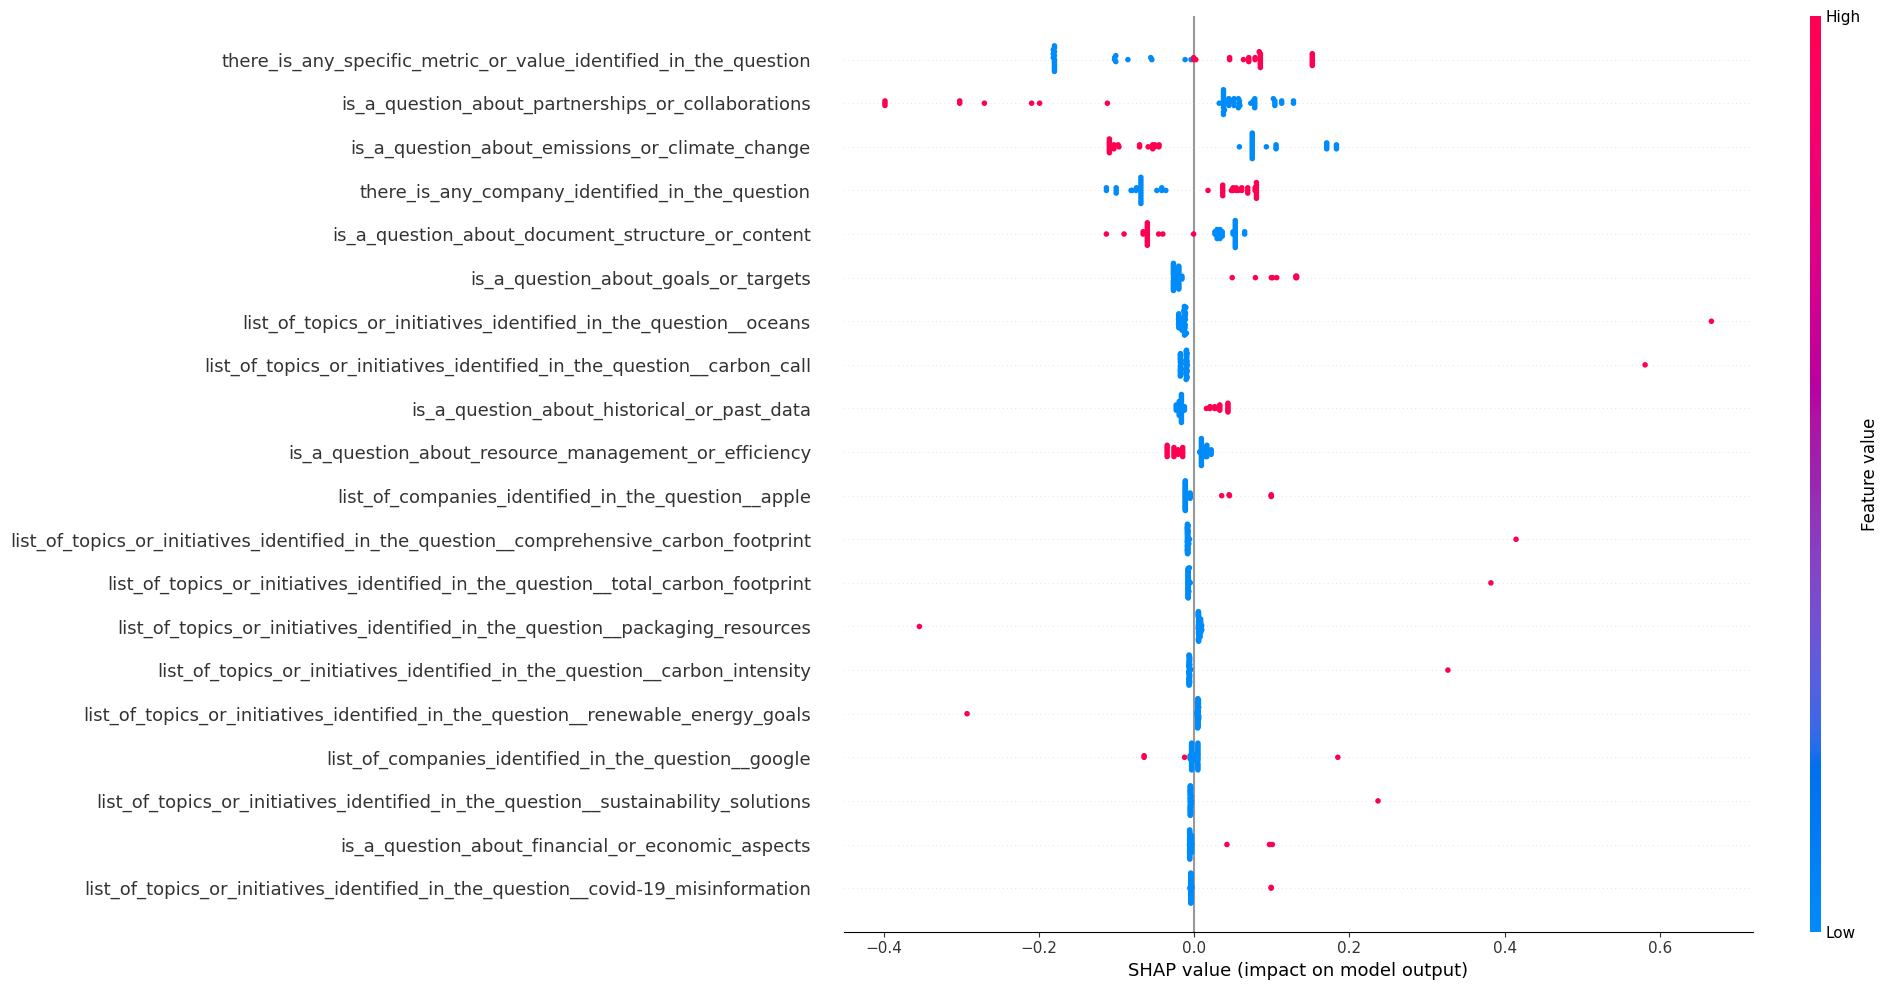

In [10]:
metric_explainer = genai_explainer.explainers_[metric]
shap_values = metric_explainer(X)
shap.summary_plot(shap_values, X, plot_size=(20,10))

### Now let's select one question

For the selected question, display the question, the retrieved contexts, the generated and expected answers, the metric value and the predicted metric from the model trained

Also, show the SHAP values for the selected question (for the previously selected metric). 
`shap.waterfall_plot` is a function in the SHAP library that visualizes the contribution of **each feature to a single prediction**. It breaks down the prediction into the base value (average model output) and the impact of each feature's SHAP value, showing how each feature pushes the prediction higher or lower. This plot helps to understand the specific reasons behind an individual prediction by displaying the cumulative effect of each feature.

Dropdown(description='Select:', index=2, options=(('What is the objective of the Carbon Call initiative?', 0),…


### INDEX 2

**USER INPUT:**
How many people in India did Microsoft provide water access to?

**RETRIEVED CONTEXT:**


**CHUNK 1:**

Chile
South Africa
16,408 
Brazil
340  
Mexico
United States
309,921
India
225,389 
Indonesia
Water Table 3 
Delivering on our water positive commitment by enabling access to water and sanitation services, and through water replenishment projects 
In FY22, Microsoft provided 552,058 people with water access across Brazil, India, Indonesia, and Mexico. From the program’s inception through December 2022, we have provided nearly one million people with water access  
across these regions. 
Since year one, we have contracted 27 replenishment programs in water-stressed basins, which are contracted to deliver more than 35 million m3 of replenishment over their lifetime. 
552,058 
Total population 
provided with water
access in FY22
27  
Total number of water 
replenishment projects   
Learn more in the Environmental Data Fact Sheet 
a. Reported access values represent data reviewed and validated by water.org. 
b. Microsoft’s reported replenishment values represent impact since program’s inception in FY18.
29
 |  |  |

**CHUNK 2:**

Improving access 
to water 
We continue to make progress towards our 
commitment to provide 1.5 million people with 
access to safe drinking water and sanitation 
solutions by 2030. One in four people across 
the globe do not have access to clean water 
and this is expected to increase as water 
challenges are exacerbated by climate change. 
In 2020, we committed to providing Water.org  
with $3 million over three years to provide 
micro-loans to cover a range of solutions, 
such as installation of household taps and 
toilets, rainwater harvesting, storage and well 
restoration for communities and schools. 
We are helping to develop resources 
that support organizations in 
understanding the different types  
of accessibility projects they can  
invest in across different types of 
water, sanitation, and health  
(WASH) solutions. 
In FY22, Microsoft’s contribution has provided more 
than 550,000 people with access to clean water and 
sanitation services in Brazil, India, Indonesia, and 
Mexico. This project reached just under one million 
people by December 2022. 
We are also helping to develop resources to support 
organizations in understanding the different types 
of accessibility projects they can invest in, as well 
how to quantify the benefits and impacts from these 
investments across different types of water, sanitation, 
and health (WASH) solutions. 
Increasing water access in Mexico 
Mexico is facing extreme water challenges as a 
result of increasing demands on water resources. 
In peri-urban towns outside of Mexico City, the local 
government subsidizes water for their residents. This is 
a common approach to help improve household access 
to water; however, it is not holistic. Patty, a healthcare 
worker, was unable to get the amount of water her 
family needed through the program. She used to wait 
hours each month to receive her household ration 
of water, taking time away from work and earning 
income. To supplement the water she did receive, 
Patty bought bottled water and saved rainwater in 
a makeshift bucket to use for cooking, laundry, and 
bathing. Contigo, a local partner of Water.org, allowed 
Patty to affordably finance a rain storage solution 
with a large tank, gutters, and a cistern to cover her 
household water needs. This represents one of the 
roughly 150,000 micro-loans that Microsoft’s funding 
has supported across the globe. 
550,000
 
In FY22, Microsoft’s 
contribution to water.
org has provided 
more than 550,000 
people with access 
to clean water. 
Our access projects empower people, families, and 
communities to do more through water access micro-loans. 
34
 |  |  | 
550,000
In FY22, Microsoft’s 
contribution to water.
org has provided 
more than 550,000 
people with access 
to clean water.

**RESPONSE:**
Microsoft provided water access to 225,389 people in India.

**REFERENCE:**
309,921

**METRIC → context_recall :** Measures how much of the relevant information in the input context is included in the output.

**METRIC Value:** 0.000

**MODEL ESTIMATED Value:** 0.052


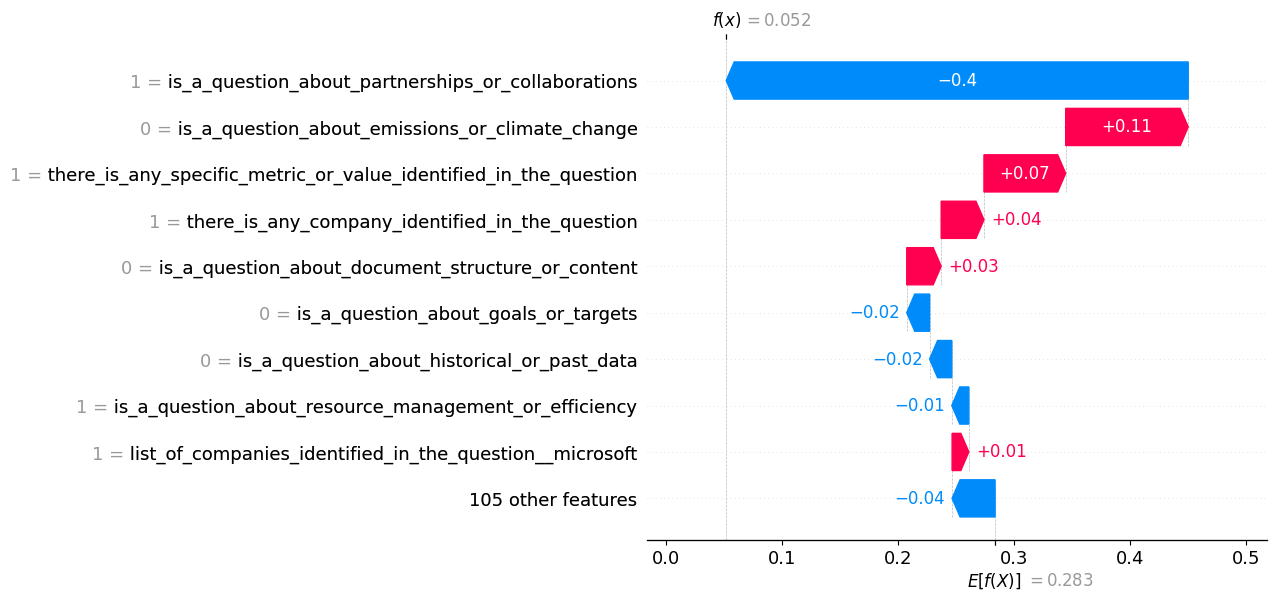

In [11]:
# Define the dropdown values
dropdown_values = df_test_dataset.iloc[:, 0].tolist()

# Create a dropdown widget
dropdown = widgets.Dropdown(
    options=[(value, index) for index, value in enumerate(dropdown_values)],
    description='Select:',
    disabled=False,
)

# Function to handle the dropdown selection
def on_change(change):
    global sel_question
    sel_question = change['new']
    # print(f'Selected question: {sel_question}')

    # Clear the previous output
    clear_output(wait=True)
    
    # Display the dropdown widget again
    display(dropdown)

    # Display the details of the selected question
    index = sel_question

    context = df_test_dataset.loc[index,'retrieved_contexts']
    context_str = "\n".join([f"\n**CHUNK {i+1}:**\n\n{c}" for i, c in zip(range(len(context)),context)])

    index_details = f"""
### INDEX {index}

**USER INPUT:**
{df_test_dataset.loc[index,'user_input']}

**RETRIEVED CONTEXT:**

{context_str}

**RESPONSE:**
{df_test_dataset.loc[index,'response']}

**REFERENCE:**
{df_test_dataset.loc[index,'reference']}

**METRIC → {metric} :** {metric_text}

**METRIC Value:** {df_test_dataset.loc[index, metric]:.3f}

**MODEL ESTIMATED Value:** {df_metric.loc[index, 'estimated_value']:.3f}
"""

    display(Markdown(index_details))
    shap.waterfall_plot(shap_values[index])

# Attach the function to the dropdown widget
dropdown.observe(on_change, names='value')

# Display the dropdown widget
display(dropdown)